## Intro to language modeling: building makemore
### Part 2: MLP

From YouTube video: https://www.youtube.com/watch?v=TCH_1BHY58I by @AndrejKarpathy

#### Library imports

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

#### Dataset import

In [43]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [44]:
# ---------- Multilayer Perceptron ---------- #

In [45]:
# build the vocab of characters and mappings to int
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [46]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context len: 
    # how many chars do we take to predict the next one?

    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size # padded
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop & append
            # rolling window of context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2]) # 3202 for validation
Xte, Yte = build_dataset(words[n2:]) # 3204 for test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [47]:
# X.shape, X.dtype, Y.shape, Y.dtype

In [48]:
len(words), n1, n2

(32033, 25626, 28829)

In [49]:
# look up table C
C = torch.randn((27,2))

In [50]:
# C[5]
# and 
# F.one_hot(torch.tensor(5), num_classes=27).float() @ C
# are the same

In [51]:
# embedding
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 2])

In [52]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# first layer
W1 = torch.randn((6,300), generator=g) # 300 neurons
b1 = torch.randn(300, generator=g) # 300 biases
# second layer
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [53]:
sum(p.nelement() for p in parameters) # num of para in total

10281

In [54]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
# use emb.shape[0] or -1

# broadcasting b1 to emb.view(emb.shape[0],6) @ W1
# -1~1

In [55]:
# # the size doesn't matter if I use cat & unbind
# # along 1st dimension
# torch.cat(torch.unbind(emb, 1), 1).shape 
# # new memory is created, not efficient enough

# arr = torch.arange(18)
# arr.view(3,3,2)

In [56]:
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1,keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean() # ideally the nums in prob[torch.arange(32), Y] will be 1
loss = F.cross_entropy(logits, Ytr)
loss

tensor(26.0615)

In [57]:
for p in parameters:
    p.requires_grad = True

In [58]:
# lre: learning rate exponent; lrs: lr search
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [59]:
lri = []
lossi = []
stepi = []

for i in range(30000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 10 ** (-0.75)
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
#     lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
    

print(loss.item())
# overfitting a single batch of the data and getting low loss

2.4364473819732666


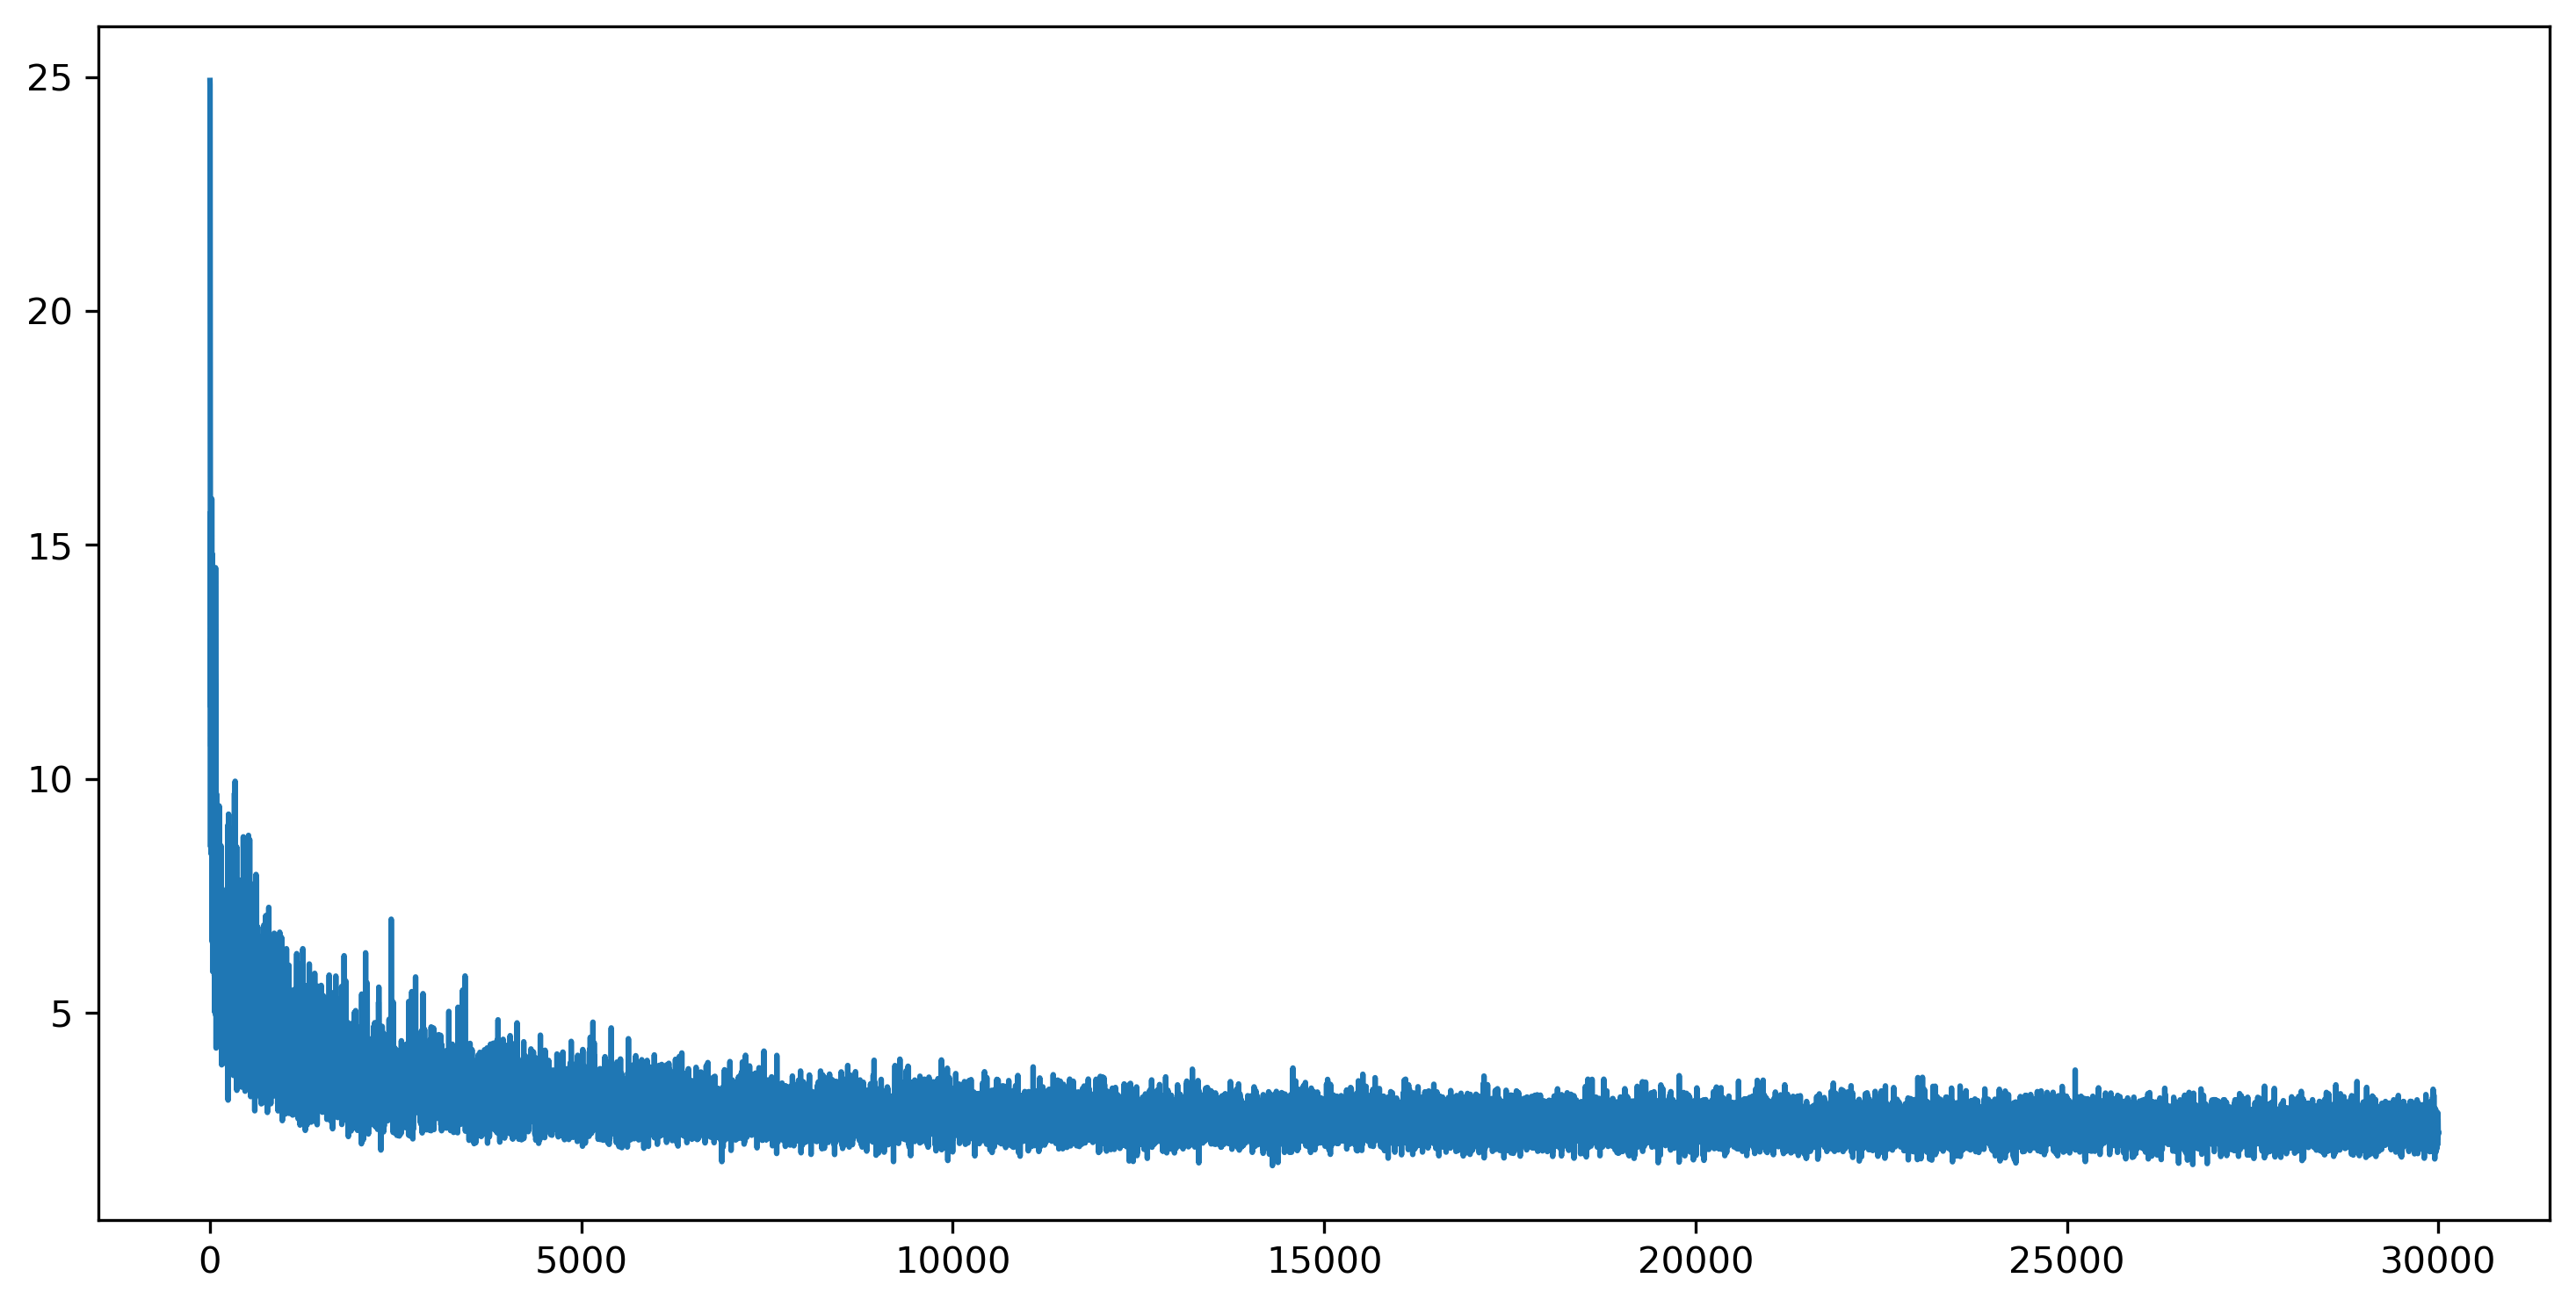

In [60]:
plt.figure(figsize=(12,6), dpi=300)
plt.plot(stepi, lossi)
# from the graph, when the exponent is -1 or -0.9
# it reaches a good learning rate

In [61]:
emb = C[Xtr] # (32,3,2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4998, grad_fn=<NllLossBackward>)

In [62]:
# training loss ~ dev loss --> small nn --> underfitting

In [63]:
emb = C[Xdev] # (32,3,2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4934, grad_fn=<NllLossBackward>)

In [64]:
# training split, dev/validation split, test split
# 80% (param), 10% (hyper param), 10% (performance)

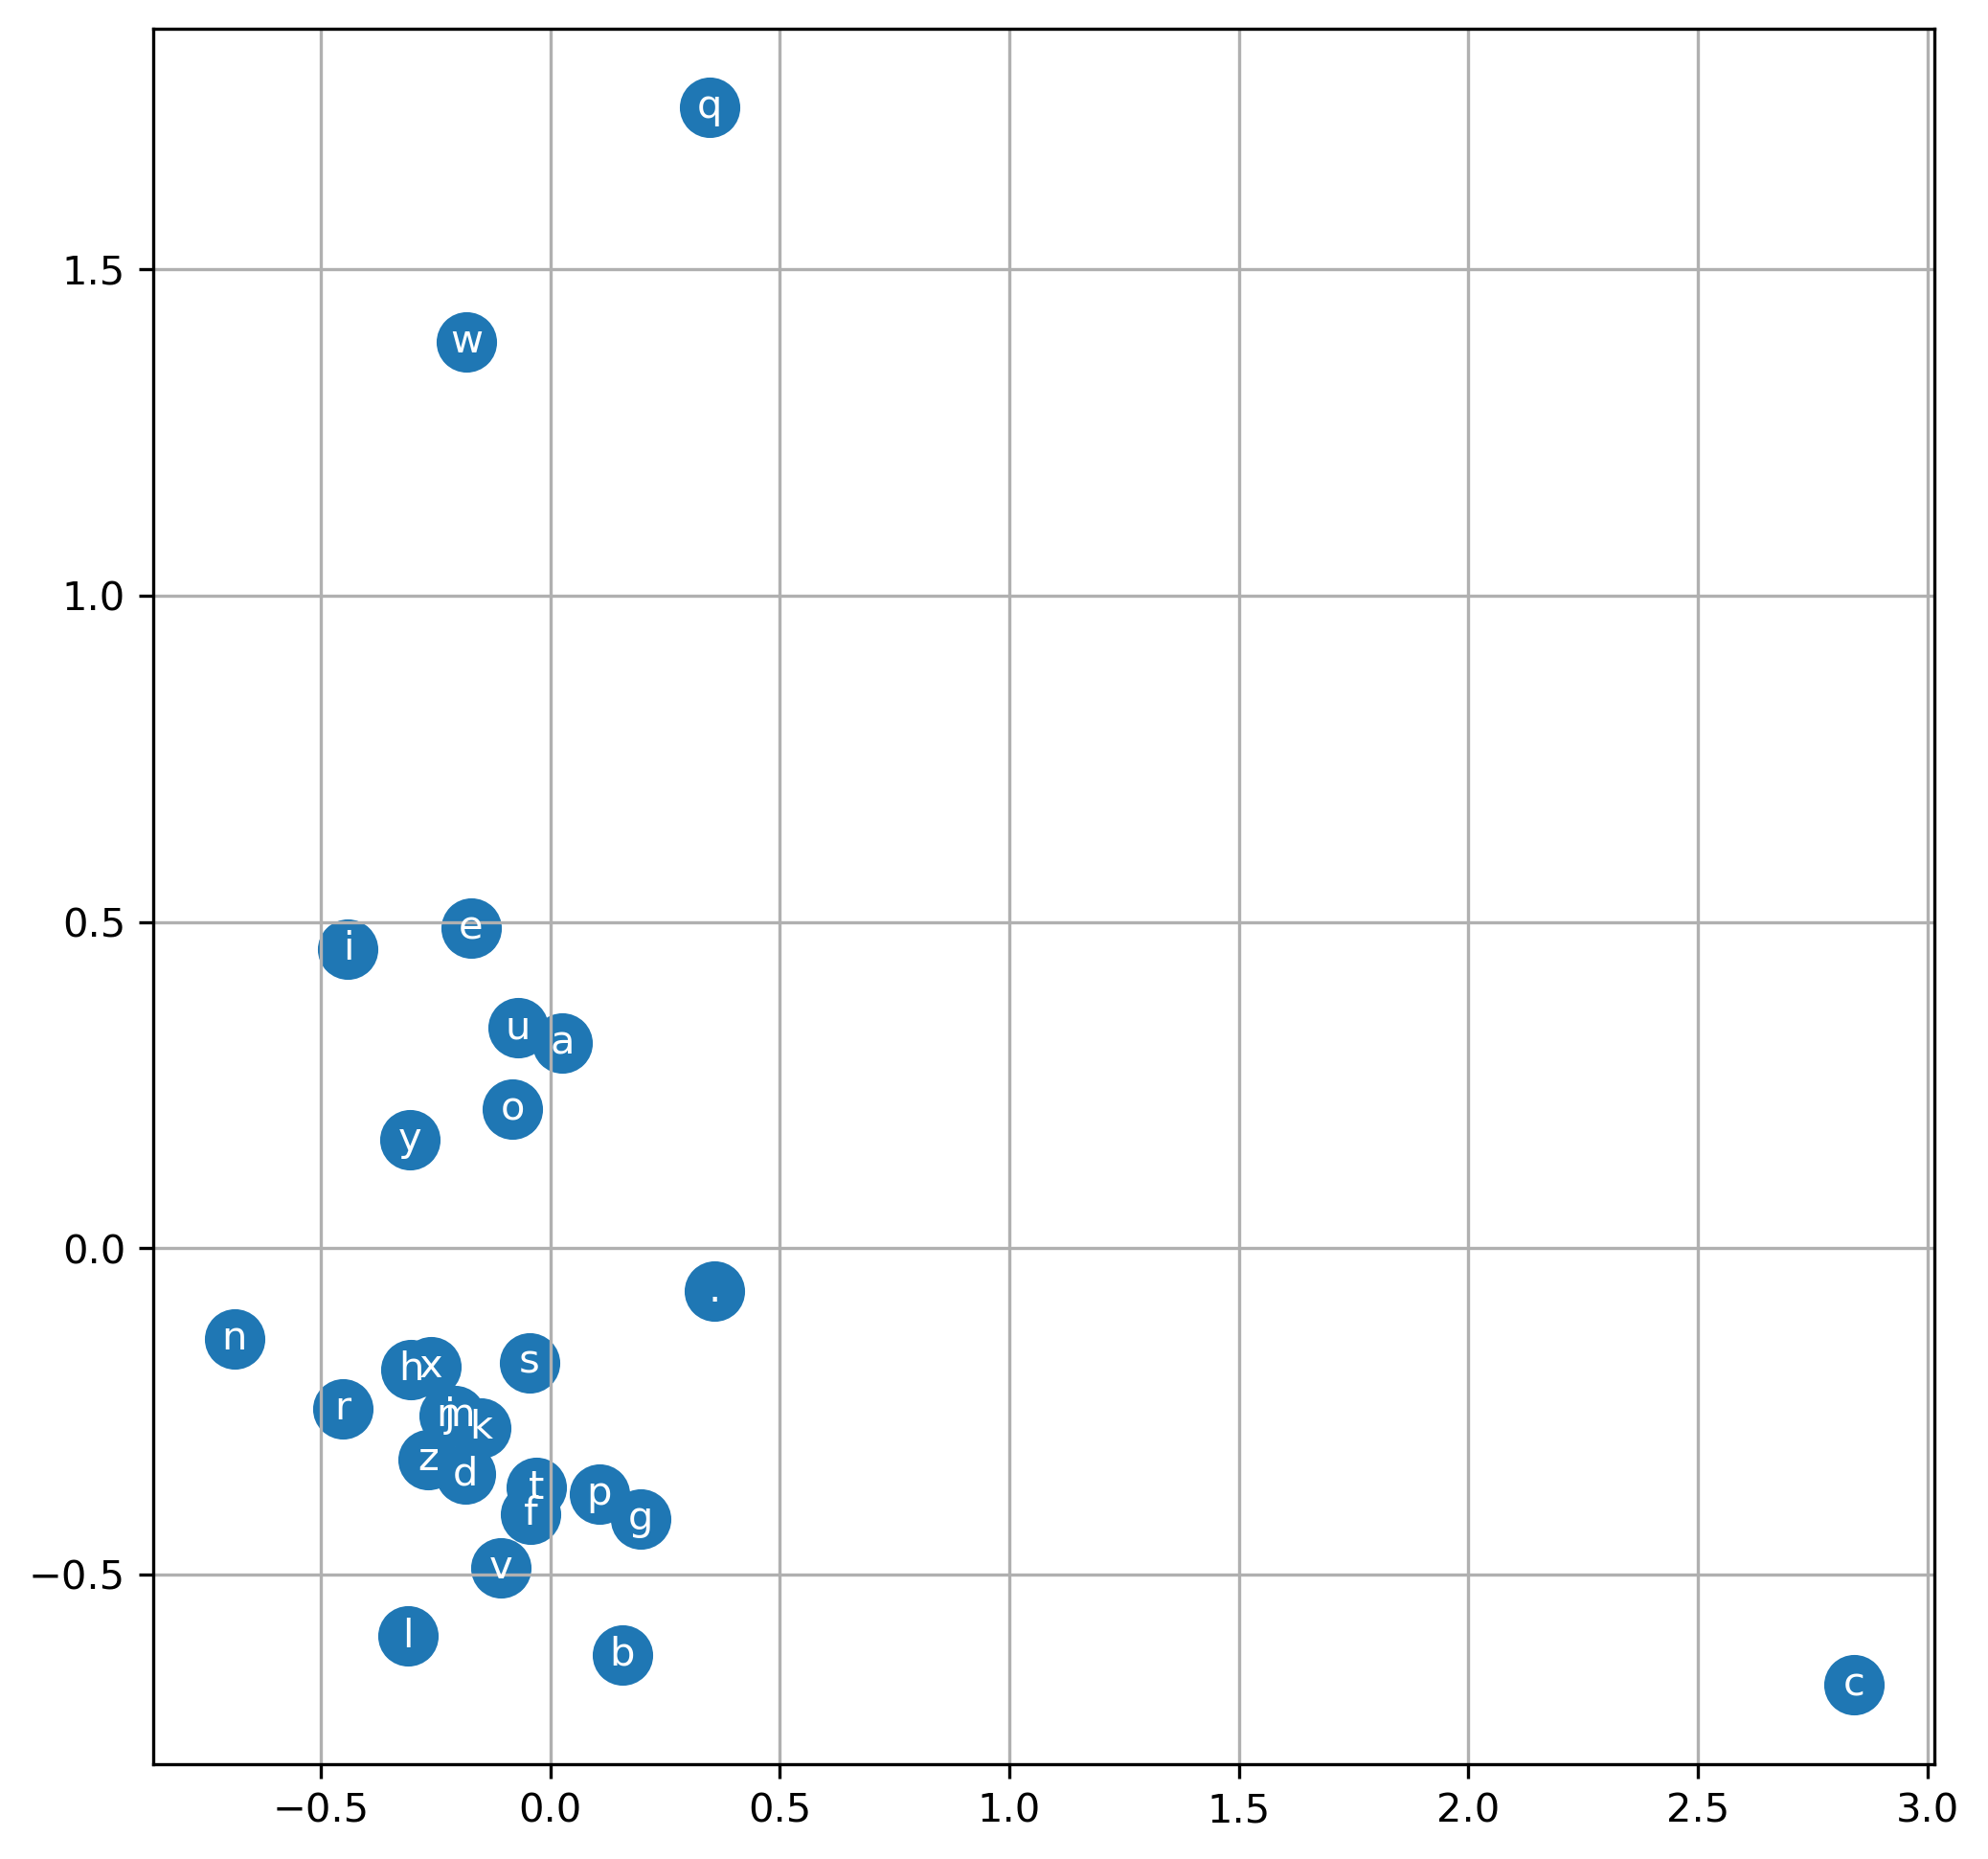

In [65]:
plt.figure(figsize=(8,8), dpi=300)
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]): # currently only 2 emb
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [66]:
# ---- change from 2D embeddings to 10D ----

In [67]:
dimension = 10
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27,dimension)) # 27 * 10D
W1 = torch.randn((3*dimension,200), generator=g) # 3*10 = 30; 200 neurons
b1 = torch.randn(200, generator=g) # 200 biases
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [68]:
sum(p.nelement() for p in parameters) # num of para in total

11897

In [69]:
for p in parameters:
    p.requires_grad = True

In [70]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [71]:
# lri = []
# lossi = []
# stepi = []

In [86]:
for i in range(200000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,3*dimension) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 10 ** (-1) if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
#     lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    

print(loss.item())
# overfitting a single batch of the data and getting low loss

2.035743474960327


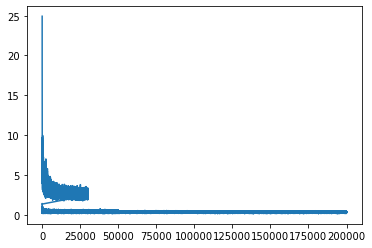

In [89]:
plt.plot(stepi, lossi)

In [87]:
emb = C[Xtr] # (32,3,2)
h = torch.tanh(emb.view(-1,3*dimension) @ W1 + b1) # (32,100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0607, grad_fn=<NllLossBackward>)

In [88]:
emb = C[Xdev] # (32,3,2)
h = torch.tanh(emb.view(-1,3*dimension) @ W1 + b1) # (32,100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss # yayy I beat 2.17

tensor(2.1297, grad_fn=<NllLossBackward>)

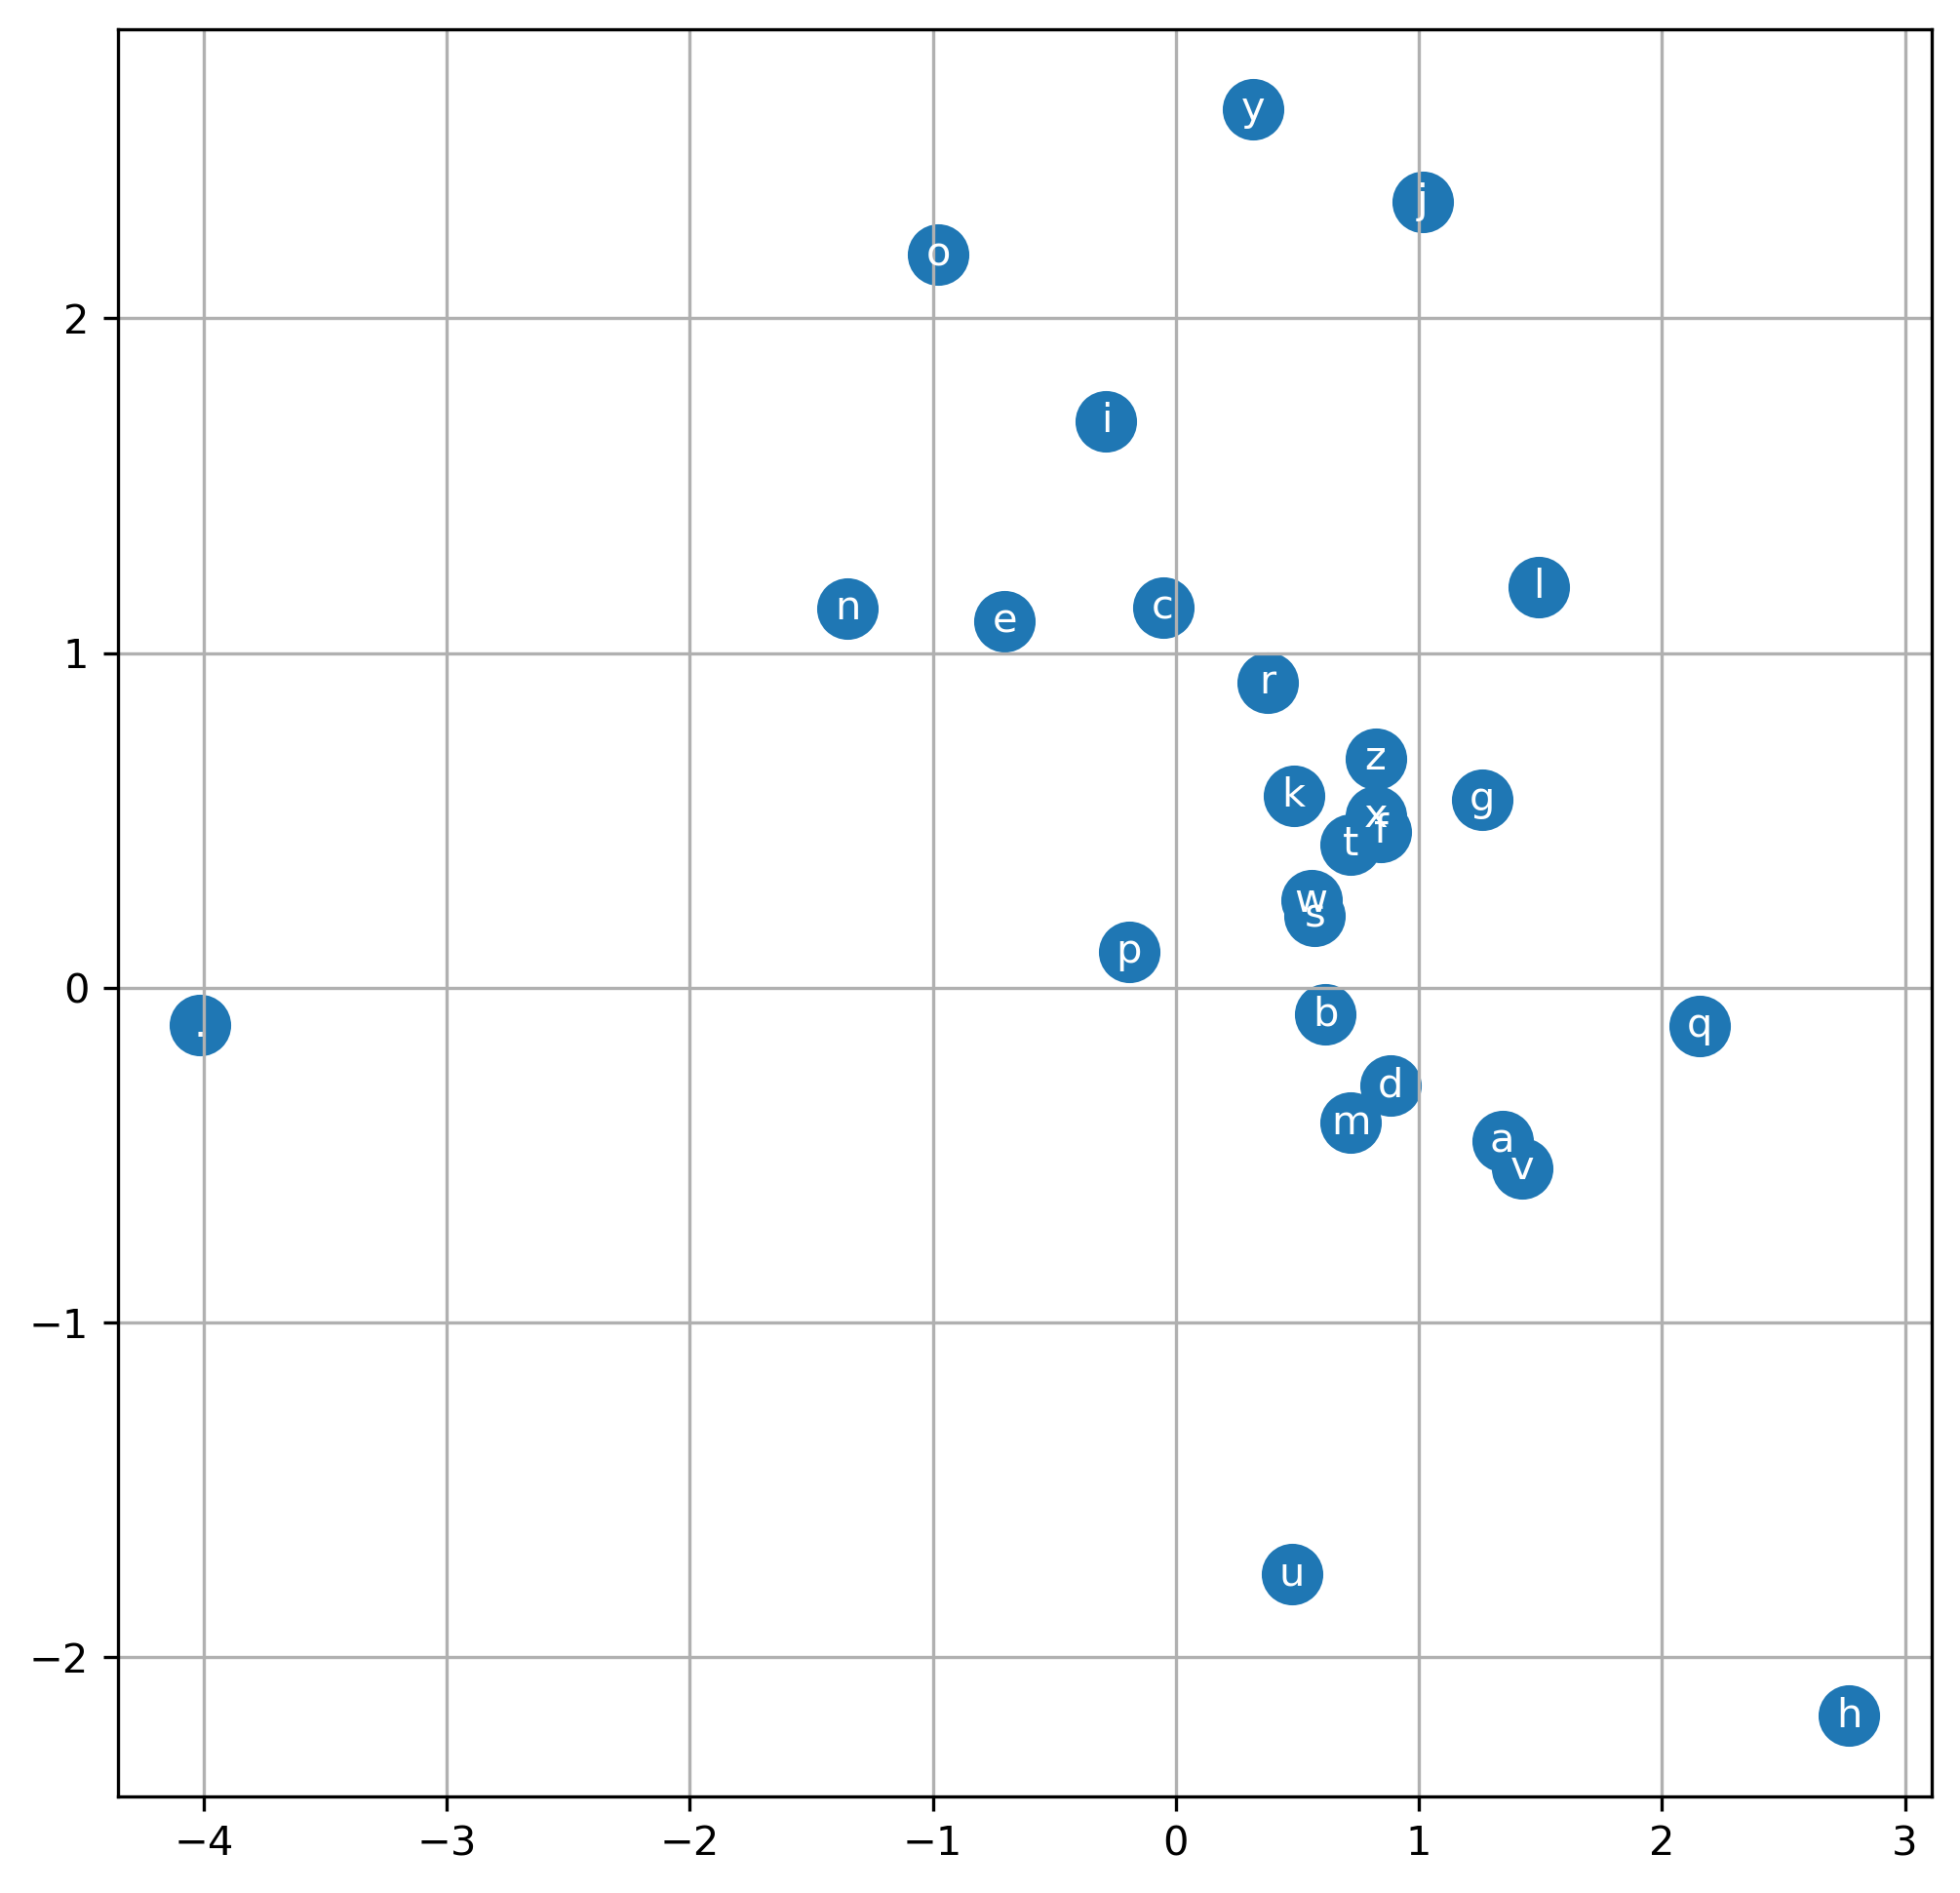

In [90]:
plt.figure(figsize=(8,8), dpi=300)
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]): # currently only 2 emb
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [91]:
# Improvements
## continue tuning the optimization
## continue changing the size of nn
## change the input from 3 char into more

In [92]:
# ---------- Extra Notes ---------- #

In [ ]:
# can replace the part of building dataset
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all
    
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tand(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i]) for i in out)